<a href="https://colab.research.google.com/github/Srikanth-Kb/Transfer-learning/blob/master/Transfer_learning_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip3 install torch torchvision

  Using cached https://files.pythonhosted.org/packages/14/41/db6dec65ddbc176a59b89485e8cc136a433ed9c6397b6bfe2cd38412051e/Pillow-6.1.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [83]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [84]:
!ls

ants_and_bees  data  sample_data


In [0]:
transform_train = transforms.Compose([transforms.Resize((224,224)),transforms.RandomHorizontalFlip(), transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
                                transforms.ColorJitter(brightness=1, contrast=1, saturation=1),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset,batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20,shuffle=False)

In [86]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image*np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [0]:
classes = ('ant', 'bee')

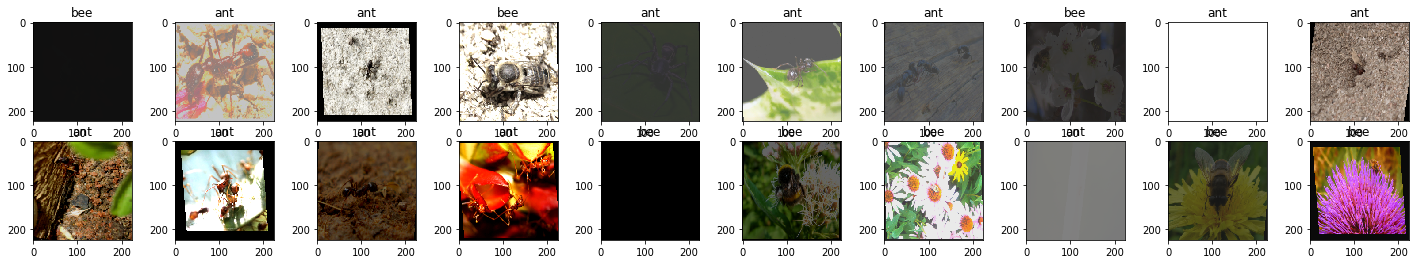

In [89]:
dataiter=iter(training_loader)
images,labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
  ax = fig.add_subplot(2,10,i+1)
  plt.imshow(im_convert(images[i]))
  ax.set_title(classes[labels[i].item()])
  


In [0]:
model = models.vgg16(pretrained=True)
    

In [91]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
for param in model.features.parameters():
  param.requires_grad = False

In [93]:
import torch.nn as nn

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [105]:
epochs = 10
running_loss_history = []
running_correct_history = list()
validation_loss_history = []
validation_accuracy_history = []

for e in range(epochs):
  running_loss = 0.0 
  running_corrects = 0.0
  val_running_loss = 0.0  
  val_running_corrects = 0.0
  for inputs,labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, prediction = torch.max(outputs,1)
    running_corrects+=torch.sum(prediction == labels.data)
    running_loss+=loss.item()
  else:
    with torch.no_grad():
      
      for val_inputs,val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds= torch.max(val_outputs,1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds==val_labels.data)
        
    
    
    print('epoch number:',e+1)
    
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)
    print('training loss:{:.4f},acc:{:.4f}'.format(epoch_loss, epoch_acc.item()))
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
    validation_loss_history.append(val_epoch_loss)
    validation_accuracy_history.append(val_epoch_acc)
    print('validation loss:{:.4f},acc:{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

    

epoch number: 1
training loss:0.0164,acc:0.8770
validation loss:0.0155,acc:0.9346
epoch number: 2
training loss:0.0113,acc:0.8975
validation loss:0.0362,acc:0.8758
epoch number: 3
training loss:0.0126,acc:0.8852
validation loss:0.0213,acc:0.9477
epoch number: 4
training loss:0.0115,acc:0.9057
validation loss:0.0254,acc:0.9085
epoch number: 5
training loss:0.0061,acc:0.9303
validation loss:0.0309,acc:0.9281
epoch number: 6
training loss:0.0068,acc:0.9385
validation loss:0.0297,acc:0.9216
epoch number: 7
training loss:0.0164,acc:0.8811
validation loss:0.0370,acc:0.9150
epoch number: 8
training loss:0.0067,acc:0.9385
validation loss:0.0359,acc:0.9020
epoch number: 9
training loss:0.0139,acc:0.8811
validation loss:0.0257,acc:0.9281
epoch number: 10
training loss:0.0091,acc:0.9221
validation loss:0.0272,acc:0.9281


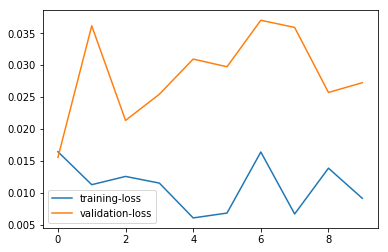

In [106]:
plt.plot(running_loss_history, label='training-loss')
plt.plot(validation_loss_history, label='validation-loss')
plt.legend()
        
        

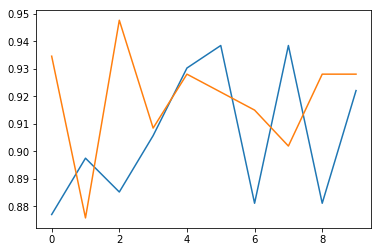

In [107]:
plt.plot(running_correct_history, label='training-accuracy')
plt.plot(validation_accuracy_history, label='validation-accuracy')


In [108]:
!pip3 install pillow==4.0.0

In [0]:
import PIL.ImageOps

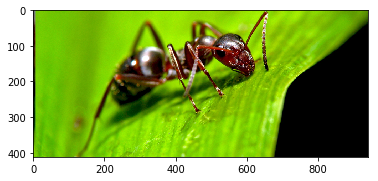

In [110]:
import requests
import PIL
url = 'https://www.mcgill.ca/oss/files/oss/styles/hd/public/ant.jpg?itok=JJlpCPSR&timestamp=1497721265'
response = requests.get(url, stream=True)
img = PIL.Image.open(response.raw)
plt.imshow(img)

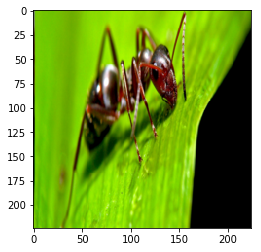

In [111]:
img = transform(img)
plt.imshow(im_convert(img))

In [112]:
image = img.to(device).unsqueeze(0)
output = model(image)
_,pred = torch.max(output,1)
print(classes[pred.item()])

ant


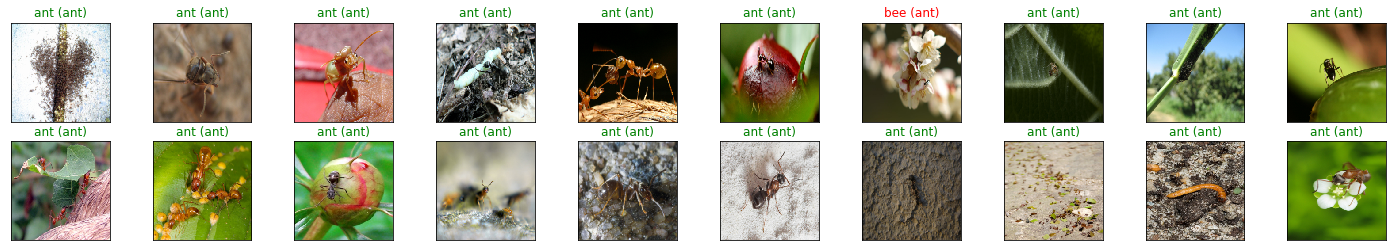

In [113]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))